# Part 3 Q2

### Imports

In [1]:
import torch
import torch.nn.functional as Func
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import copy
import os
import librosa
import matplotlib.pyplot as plt

### Calculate IBM Mask

In [2]:
def ibm(clean, dirty, extent = None, plot=False):
    noise = dirty - clean
    
    ibm_mask = np.zeros((dirty.shape))
    ibm_mask[clean >= noise] = 1
    
    if plot:
        plt.title('Noise Component')
        plt.xlabel('Time (in secs)')
        plt.ylabel('Frequency (in Hz)')
        plt.imshow(noise, origin = 'lowest', aspect = 'auto', extent = extent)
        plt.show()
        
        plt.title('IBM Mask')
        plt.xlabel('Time (in secs)')
        plt.ylabel('Frequency (in Hz)')
        plt.imshow(ibm_mask, origin = 'lowest', aspect = 'auto', extent = extent)
        plt.show()
    
    return torch.tensor(ibm_mask, dtype = torch.float32)

### Calculate IRM Mask

In [3]:
def irm(clean, dirty, extent = None ,plot=False):
    noise = dirty - clean
    clean_2 = clean**2
    irm_mask = np.sqrt(clean_2/(clean_2 + noise**2))
    
    if plot:
        plt.title('IRM Mask')
        plt.xlabel('Time (in secs)')
        plt.ylabel('Frequency (in Hz)')
        plt.imshow(irm_mask, origin = 'lowest', aspect = 'auto', extent = extent)
        plt.show()
        
    return torch.tensor(irm_mask, dtype = torch.float32)

### Calculate FFT Mask

In [4]:
def fft_mask(clean, dirty, extent = None, plot=False):
    #clip function truncates the label to values between 0 and 1 (inclusively).
    
    mask = np.clip(clean/dirty, 0, 1)
    if plot:
        plt.title('FFT Mask')
        plt.xlabel('Time (in secs)')
        plt.ylabel('Frequency (in Hz)')
        plt.imshow(mask, origin = 'lowest', aspect = 'auto', extent = extent)
        plt.show()
    
    return torch.tensor(mask, dtype = torch.float32)

Take one of your noisy speech signals (and corresponding speech and noise components) and generate the IBM and IRM masks. Plot the spectrograms for the noisy speech signal, clean speech component, noise component and appropriately label all axis. Also, generate plots for the corresponding IBM and IRM.

In [5]:
dirty_path = './GeneratedData/Test/Dirty/'
clean_path = './GeneratedData/Test/Clean/'
noisyfile = dirty_path + 'dirty_2.wav'
cleanfile = clean_path + 'clean_2.wav'

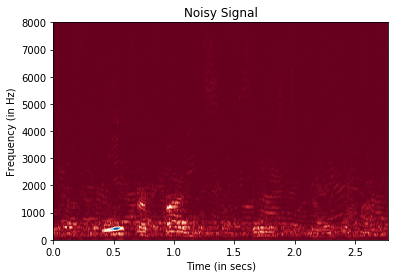

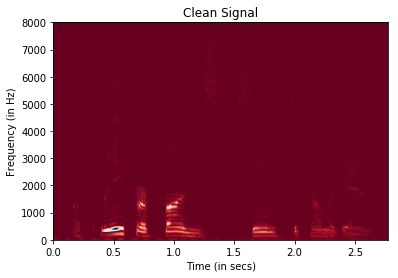

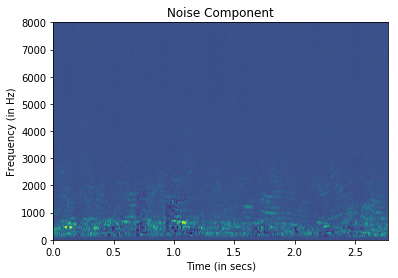

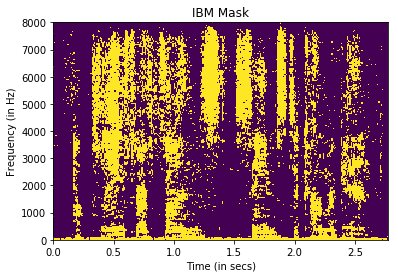

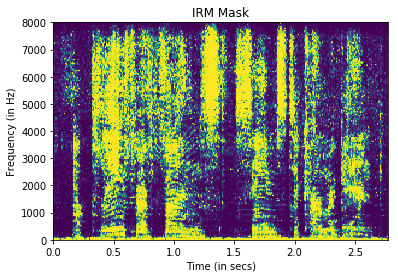

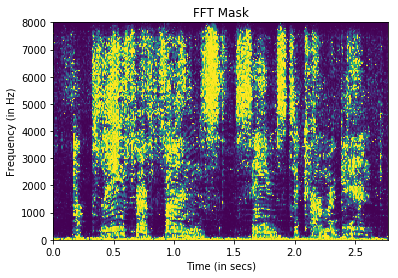

In [6]:
ss,sr = librosa.load(noisyfile, sr = None)
dirty = np.abs(librosa.stft(ss, n_fft = 512, hop_length = 160, win_length = 320))

ss, sr = librosa.load(cleanfile, sr = None)
clean = np.abs(librosa.stft(ss, n_fft = 512, hop_length = 160, win_length = 320))

extent=[0, len(ss)/sr, 0, 8000]

plt.title('Noisy Signal')
plt.xlabel('Time (in secs)')
plt.ylabel('Frequency (in Hz)')
plt.imshow(dirty, origin = 'lowest', aspect = 'auto', cmap = 'RdBu', extent = extent)
plt.show()

plt.title('Clean Signal')
plt.xlabel('Time (in secs)')
plt.ylabel('Frequency (in Hz)')
plt.imshow(clean, origin = 'lowest', aspect = 'auto', cmap = 'RdBu', extent = extent)
plt.show()
        

_ = ibm(clean, dirty, extent = extent, plot=True)
_ = irm(clean, dirty, extent = extent, plot=True)
_ = fft_mask(clean, dirty, extent = extent, plot=True)

### Network Architecture

As discussed in the paper the Neural Network had 3 hidden layers with 1024 units. And Dropout Rate used was 0.2 for each of those hidden layers.    

Also ReLU is used as activation.     

In the Paper momentum is constantly changed but as I've used Adam Optimizer it handles the momentum automatically  

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(257,1024)
        self.fc2 = nn.Linear(1024,1024)
        self.fc3 = nn.Linear(1024,1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024,257)
        self.drop = nn.Dropout(0.2)
        
        
    def forward(self,audio):
        audio = Func.relu(self.fc1(audio))
        audio = self.drop(Func.relu(self.fc2(audio)))
        audio = self.drop(Func.relu(self.fc3(audio)))
        audio = self.drop(Func.relu(self.fc4(audio)))
        audio = self.fc5(audio)
        return audio   

In [7]:
def weights(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data,0.1)

In [8]:
model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()
model = model.to(device)
criterion.cuda()

MSELoss()

In [10]:
#Dataloader for traning data
class trainDataLoader(data.Dataset):
    def __init__(self, input_data):
        if input_data == 'norm':
            self.file = 'norm_train.npy'
        elif input_data == 'std':
            self.file = 'std_train.npy'
        else:
            print('error')
        
        self.dataPath = './GeneratedData/npy/'
        self.dirty_file = np.load(self.dataPath + 'dirty_train.npy')
        self.clean_file = np.load(self.dataPath + 'clean_train.npy')
        self.norm_file = np.load(self.dataPath + self.file)
            
    def __getitem__(self, index):
        dirty = self.dirty_file[:, index]
        norm = self.norm_file[:, index]
        clean = self.clean_file[:, index]
        return torch.from_numpy(dirty), torch.from_numpy(clean), torch.from_numpy(norm)
    
    def __len__(self):
        return self.dirty_file.shape[1]

In [11]:
# #Dataloader for traning data
class valDataLoader(data.Dataset):
    def __init__(self, input_data):
        if input_data == 'norm':
            self.file = 'norm_dev.npy'
        elif input_data == 'std':
            self.file = 'std_dev.npy'
        else:
            print('error')
        
        self.dataPath = './GeneratedData/npy/'
        self.dirty_file = np.load(self.dataPath + 'dirty_dev.npy')
        self.clean_file = np.load(self.dataPath + 'clean_dev.npy')
        self.norm_file = np.load(self.dataPath + self.file)
            
    def __getitem__(self, index):
        dirty = self.dirty_file[:, index]
        norm = self.norm_file[:, index]
        clean = self.clean_file[:, index]
        return torch.from_numpy(dirty), torch.from_numpy(clean), torch.from_numpy(norm)
        
    def __len__(self):
        return self.dirty_file.shape[1]

In [11]:
def train_model(trainData, valData, mask, model = model, num_epochs = 20, criterion = criterion, optimizer=optimizer, device=device):
    best_model = copy.deepcopy(model.state_dict())
    best_loss = 9999
    val_loss = []
    train_loss = []
    
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        loss = 0.0 
        vali_loss = 0.0
        train_steps = 0
        dev_steps = 0
        
        for step, (dirty_data, clean_data, norm_data) in enumerate(trainData): 
            if mask == 'ibm':
                target = ibm(clean_data, dirty_data)
            elif mask == 'irm':
                target = irm(clean_data, dirty_data)
            elif mask == 'fft_mask':
                target = fft_mask(clean_data, dirty_data)
            else:
                target = torch.tensor(clean_data, dtype = torch.float32)
                
            norm = torch.tensor(norm_data, dtype = torch.float32)
            norm = norm.to(device)
            target = target.to(device)
            model.train()
            output = model(norm)
            newLoss = criterion(output,target)
            loss += newLoss.data
            #print(step,loss)
            optimizer.zero_grad()
            newLoss.backward()
            optimizer.step()
            train_steps += 1
#             print("Train step:"+str(step)+"/"+str(len(trainData)))

        for step, (dirty_data, clean_data, norm_data) in enumerate(valData): 
            if mask == 'ibm':
                target = ibm(clean_data, dirty_data)
            elif mask == 'irm':
                target = irm(clean_data, dirty_data)
            elif mask == 'fft_mask':
                target = fft_mask(clean_data, dirty_data)
            else:
                target = torch.tensor(clean_data, dtype = torch.float32)
                
            norm = torch.tensor(norm_data, dtype = torch.float32)
            norm = norm.to(device)

            target = target.to(device)        
            model.eval()
            output = model(norm)
            new_valiLoss = criterion(output,target)
            vali_loss += new_valiLoss.data
            #print(step,vali_loss)
            if vali_loss < best_loss:
                    best_loss = vali_loss
                    best_model = copy.deepcopy(model.state_dict())
            dev_steps += 1
#             print("Valid step:"+str(step)+"/"+str(len(valData)))
        
        loss = loss/train_steps
        vali_loss = vali_loss/dev_steps
        train_loss.append(loss)
        val_loss.append(vali_loss)
        print('Epoch:{:2},Loss:{:>.5f}'.format(epoch,loss))
        print('Epoch:{:2},Loss:{:>.5f}'.format(epoch,vali_loss)) 
        
    return best_model, train_loss, val_loss

## For Normalized Data 

In [14]:
trainData = data.DataLoader(trainDataLoader("norm"),batch_size = 20000,shuffle=True, drop_last = False) 
valData = data.DataLoader(valDataLoader("norm"),batch_size = 20000,shuffle=True, drop_last = False) 

### IBM

In [15]:
best_model, train_loss, val_loss = train_model(trainData, valData, 'ibm')
torch.save(best_model, './norm_ibm_model.pth')

Epoch 0/19


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0,Loss:0.19179
Epoch: 0,Loss:0.18201
Epoch 1/19
Epoch: 1,Loss:0.18511
Epoch: 1,Loss:0.16927
Epoch 2/19
Epoch: 2,Loss:0.18569
Epoch: 2,Loss:0.18439
Epoch 3/19
Epoch: 3,Loss:0.17801
Epoch: 3,Loss:0.16987
Epoch 4/19
Epoch: 4,Loss:0.17046
Epoch: 4,Loss:0.16702
Epoch 5/19
Epoch: 5,Loss:0.16789
Epoch: 5,Loss:0.16659
Epoch 6/19
Epoch: 6,Loss:0.16401
Epoch: 6,Loss:0.15915
Epoch 7/19
Epoch: 7,Loss:0.15984
Epoch: 7,Loss:0.15722
Epoch 8/19
Epoch: 8,Loss:0.15692
Epoch: 8,Loss:0.15252
Epoch 9/19
Epoch: 9,Loss:0.15542
Epoch: 9,Loss:0.15080
Epoch 10/19
Epoch:10,Loss:0.15194
Epoch:10,Loss:0.15649
Epoch 11/19
Epoch:11,Loss:0.15093
Epoch:11,Loss:0.14797
Epoch 12/19
Epoch:12,Loss:0.14875
Epoch:12,Loss:0.15079
Epoch 13/19
Epoch:13,Loss:0.15267
Epoch:13,Loss:0.14773
Epoch 14/19
Epoch:14,Loss:0.14886
Epoch:14,Loss:0.14738
Epoch 15/19
Epoch:15,Loss:0.14753
Epoch:15,Loss:0.14694
Epoch 16/19
Epoch:16,Loss:0.14506
Epoch:16,Loss:0.15167
Epoch 17/19
Epoch:17,Loss:0.14367
Epoch:17,Loss:0.14716
Epoch 18/19
E

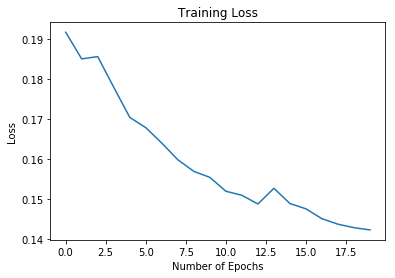

In [16]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.plot(train_loss)
plt.show()

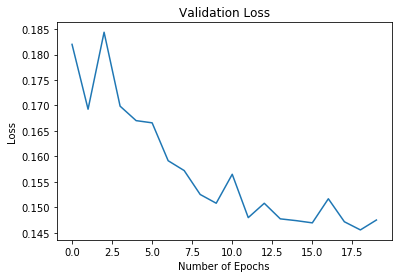

In [18]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.plot(val_loss)
plt.show()

### IRM

In [19]:
best_model, train_loss, val_loss = train_model(trainData, valData, 'irm')
torch.save(best_model, './norm_irm_model.pth')

Epoch 0/19


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0,Loss:0.10747
Epoch: 0,Loss:0.10017
Epoch 1/19
Epoch: 1,Loss:0.09863
Epoch: 1,Loss:0.09867
Epoch 2/19
Epoch: 2,Loss:0.09707
Epoch: 2,Loss:0.09814
Epoch 3/19
Epoch: 3,Loss:0.09546
Epoch: 3,Loss:0.09748
Epoch 4/19
Epoch: 4,Loss:0.09489
Epoch: 4,Loss:0.10031
Epoch 5/19
Epoch: 5,Loss:0.09388
Epoch: 5,Loss:0.09695
Epoch 6/19
Epoch: 6,Loss:0.09385
Epoch: 6,Loss:0.09695
Epoch 7/19
Epoch: 7,Loss:0.09305
Epoch: 7,Loss:0.09703
Epoch 8/19
Epoch: 8,Loss:0.09273
Epoch: 8,Loss:0.09685
Epoch 9/19
Epoch: 9,Loss:0.09251
Epoch: 9,Loss:0.09734
Epoch 10/19
Epoch:10,Loss:0.09202
Epoch:10,Loss:0.09842
Epoch 11/19
Epoch:11,Loss:0.09193
Epoch:11,Loss:0.09494
Epoch 12/19
Epoch:12,Loss:0.09186
Epoch:12,Loss:0.09661
Epoch 13/19
Epoch:13,Loss:0.09130
Epoch:13,Loss:0.09488
Epoch 14/19
Epoch:14,Loss:0.09108
Epoch:14,Loss:0.09697
Epoch 15/19
Epoch:15,Loss:0.09092
Epoch:15,Loss:0.09511
Epoch 16/19
Epoch:16,Loss:0.09041
Epoch:16,Loss:0.09529
Epoch 17/19
Epoch:17,Loss:0.09092
Epoch:17,Loss:0.09182
Epoch 18/19
E

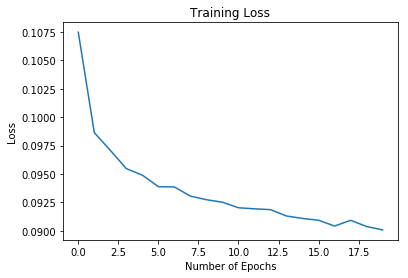

In [20]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.plot(train_loss)
plt.show()

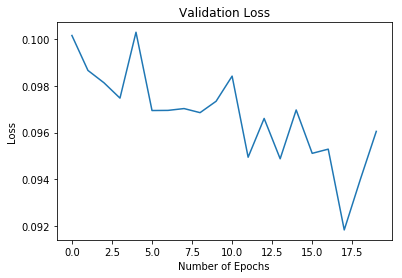

In [21]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.plot(val_loss)
plt.show()

### FFT Mask

In [22]:
best_model, train_loss, val_loss = train_model(trainData, valData, 'fft_mask')
torch.save(best_model, './norm_fft_model.pth')

Epoch 0/19


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0,Loss:0.07732
Epoch: 0,Loss:0.07912
Epoch 1/19
Epoch: 1,Loss:0.07647
Epoch: 1,Loss:0.07894
Epoch 2/19
Epoch: 2,Loss:0.07626
Epoch: 2,Loss:0.08358
Epoch 3/19
Epoch: 3,Loss:0.07634
Epoch: 3,Loss:0.08018
Epoch 4/19
Epoch: 4,Loss:0.07627
Epoch: 4,Loss:0.08041
Epoch 5/19
Epoch: 5,Loss:0.07592
Epoch: 5,Loss:0.07964
Epoch 6/19
Epoch: 6,Loss:0.07598
Epoch: 6,Loss:0.07750
Epoch 7/19
Epoch: 7,Loss:0.07578
Epoch: 7,Loss:0.07903
Epoch 8/19
Epoch: 8,Loss:0.07573
Epoch: 8,Loss:0.07861
Epoch 9/19
Epoch: 9,Loss:0.07567
Epoch: 9,Loss:0.07831
Epoch 10/19
Epoch:10,Loss:0.07553
Epoch:10,Loss:0.07744
Epoch 11/19
Epoch:11,Loss:0.07547
Epoch:11,Loss:0.07974
Epoch 12/19
Epoch:12,Loss:0.07526
Epoch:12,Loss:0.07918
Epoch 13/19
Epoch:13,Loss:0.07515
Epoch:13,Loss:0.07636
Epoch 14/19
Epoch:14,Loss:0.07496
Epoch:14,Loss:0.07649
Epoch 15/19
Epoch:15,Loss:0.07482
Epoch:15,Loss:0.07765
Epoch 16/19
Epoch:16,Loss:0.07490
Epoch:16,Loss:0.07781
Epoch 17/19
Epoch:17,Loss:0.07509
Epoch:17,Loss:0.07861
Epoch 18/19
E

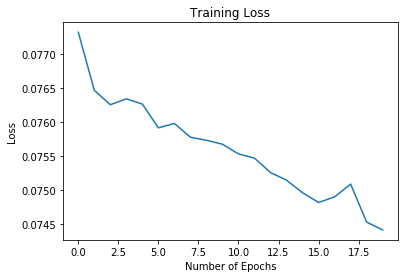

In [23]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.plot(train_loss)
plt.show()

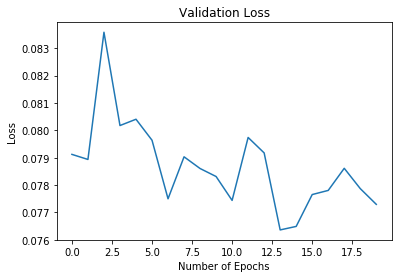

In [24]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.plot(val_loss)
plt.show()

### Spectrogram

In [25]:
best_model, train_loss, val_loss = train_model(trainData, valData, 'spectrogram')
torch.save(best_model, './norm_spec_model.pth')

Epoch 0/19


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceT

Epoch: 0,Loss:0.15562
Epoch: 0,Loss:0.14043
Epoch 1/19
Epoch: 1,Loss:0.14706
Epoch: 1,Loss:0.15282
Epoch 2/19
Epoch: 2,Loss:0.14773
Epoch: 2,Loss:0.13892
Epoch 3/19
Epoch: 3,Loss:0.13842
Epoch: 3,Loss:0.13496
Epoch 4/19
Epoch: 4,Loss:0.14207
Epoch: 4,Loss:0.14815
Epoch 5/19
Epoch: 5,Loss:0.13578
Epoch: 5,Loss:0.12594
Epoch 6/19
Epoch: 6,Loss:0.14205
Epoch: 6,Loss:0.13810
Epoch 7/19
Epoch: 7,Loss:0.13552
Epoch: 7,Loss:0.14047
Epoch 8/19
Epoch: 8,Loss:0.12523
Epoch: 8,Loss:0.15862
Epoch 9/19
Epoch: 9,Loss:0.11462
Epoch: 9,Loss:0.15314
Epoch 10/19
Epoch:10,Loss:0.10613
Epoch:10,Loss:0.14197
Epoch 11/19
Epoch:11,Loss:0.10556
Epoch:11,Loss:0.13358
Epoch 12/19
Epoch:12,Loss:0.09724
Epoch:12,Loss:0.12598
Epoch 13/19
Epoch:13,Loss:0.09250
Epoch:13,Loss:0.13115
Epoch 14/19
Epoch:14,Loss:0.09312
Epoch:14,Loss:0.10861
Epoch 15/19
Epoch:15,Loss:0.09038
Epoch:15,Loss:0.11599
Epoch 16/19
Epoch:16,Loss:0.08918
Epoch:16,Loss:0.10212
Epoch 17/19
Epoch:17,Loss:0.08655
Epoch:17,Loss:0.10427
Epoch 18/19
E

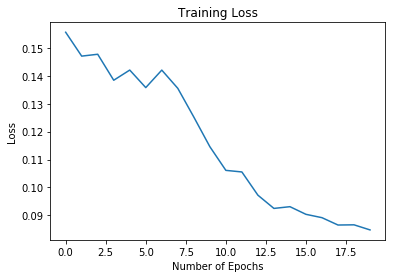

In [26]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.plot(train_loss)
plt.show()

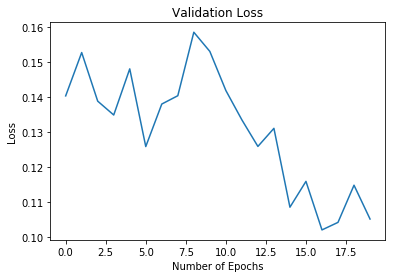

In [27]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.plot(val_loss)
plt.show()

## For Standardized Data

In [12]:
trainData = data.DataLoader(trainDataLoader("std"),batch_size = 20000,shuffle=True, drop_last = False) 
valData = data.DataLoader(valDataLoader("std"),batch_size = 20000,shuffle=True, drop_last = False) 

### IBM

In [13]:
best_model, train_loss, val_loss = train_model(trainData, valData, 'ibm')
torch.save(best_model, './std_ibm_model.pth')

Epoch 0/19


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0,Loss:0.16033
Epoch: 0,Loss:0.18226
Epoch 1/19
Epoch: 1,Loss:0.13700
Epoch: 1,Loss:0.18571
Epoch 2/19
Epoch: 2,Loss:0.13258
Epoch: 2,Loss:0.18498
Epoch 3/19
Epoch: 3,Loss:0.12980
Epoch: 3,Loss:0.18516
Epoch 4/19
Epoch: 4,Loss:0.12782
Epoch: 4,Loss:0.18881
Epoch 5/19
Epoch: 5,Loss:0.12620
Epoch: 5,Loss:0.18738
Epoch 6/19
Epoch: 6,Loss:0.12493
Epoch: 6,Loss:0.18914
Epoch 7/19
Epoch: 7,Loss:0.12384
Epoch: 7,Loss:0.18820
Epoch 8/19
Epoch: 8,Loss:0.12282
Epoch: 8,Loss:0.18871
Epoch 9/19
Epoch: 9,Loss:0.12195
Epoch: 9,Loss:0.18868
Epoch 10/19
Epoch:10,Loss:0.12131
Epoch:10,Loss:0.19166
Epoch 11/19
Epoch:11,Loss:0.12041
Epoch:11,Loss:0.19016
Epoch 12/19
Epoch:12,Loss:0.11967
Epoch:12,Loss:0.19197
Epoch 13/19
Epoch:13,Loss:0.11908
Epoch:13,Loss:0.19473
Epoch 14/19
Epoch:14,Loss:0.11854
Epoch:14,Loss:0.19414
Epoch 15/19
Epoch:15,Loss:0.11806
Epoch:15,Loss:0.19316
Epoch 16/19
Epoch:16,Loss:0.11748
Epoch:16,Loss:0.19098
Epoch 17/19
Epoch:17,Loss:0.11716
Epoch:17,Loss:0.19444
Epoch 18/19
E

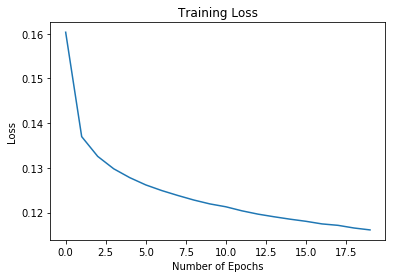

In [14]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.plot(train_loss)
plt.show()

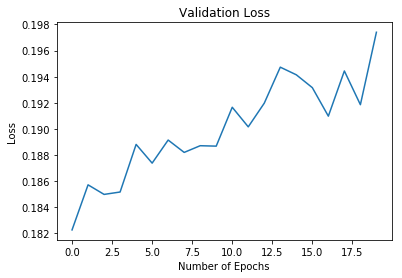

In [15]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.plot(val_loss)
plt.show()

### IRM

In [16]:
best_model, train_loss, val_loss = train_model(trainData, valData, 'irm')
torch.save(best_model, './std_irm_model.pth')

Epoch 0/19


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0,Loss:0.07419
Epoch: 0,Loss:0.14169
Epoch 1/19
Epoch: 1,Loss:0.07121
Epoch: 1,Loss:0.14382
Epoch 2/19
Epoch: 2,Loss:0.07064
Epoch: 2,Loss:0.14587
Epoch 3/19
Epoch: 3,Loss:0.07017
Epoch: 3,Loss:0.14634
Epoch 4/19
Epoch: 4,Loss:0.06981
Epoch: 4,Loss:0.14683
Epoch 5/19
Epoch: 5,Loss:0.06947
Epoch: 5,Loss:0.14686
Epoch 6/19
Epoch: 6,Loss:0.06913
Epoch: 6,Loss:0.14736
Epoch 7/19
Epoch: 7,Loss:0.06885
Epoch: 7,Loss:0.14486
Epoch 8/19
Epoch: 8,Loss:0.06851
Epoch: 8,Loss:0.14871
Epoch 9/19
Epoch: 9,Loss:0.06833
Epoch: 9,Loss:0.14315
Epoch 10/19
Epoch:10,Loss:0.06794
Epoch:10,Loss:0.14707
Epoch 11/19
Epoch:11,Loss:0.06766
Epoch:11,Loss:0.14994
Epoch 12/19
Epoch:12,Loss:0.06743
Epoch:12,Loss:0.14684
Epoch 13/19
Epoch:13,Loss:0.06717
Epoch:13,Loss:0.14908
Epoch 14/19
Epoch:14,Loss:0.06698
Epoch:14,Loss:0.14598
Epoch 15/19
Epoch:15,Loss:0.06675
Epoch:15,Loss:0.14890
Epoch 16/19
Epoch:16,Loss:0.06654
Epoch:16,Loss:0.14773
Epoch 17/19
Epoch:17,Loss:0.06637
Epoch:17,Loss:0.14769
Epoch 18/19
E

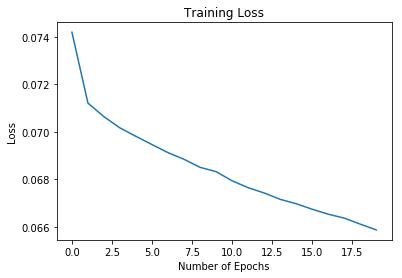

In [17]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.plot(train_loss)
plt.show()

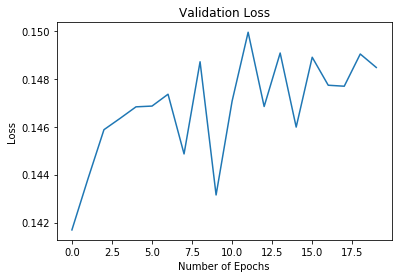

In [18]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.plot(val_loss)
plt.show()

### FFT Mask

In [19]:
best_model, train_loss, val_loss = train_model(trainData, valData, 'fft_mask')
torch.save(best_model, './std_fft_model.pth')

Epoch 0/19


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0,Loss:0.05716
Epoch: 0,Loss:0.12573
Epoch 1/19
Epoch: 1,Loss:0.05661
Epoch: 1,Loss:0.12544
Epoch 2/19
Epoch: 2,Loss:0.05649
Epoch: 2,Loss:0.12588
Epoch 3/19
Epoch: 3,Loss:0.05639
Epoch: 3,Loss:0.12566
Epoch 4/19
Epoch: 4,Loss:0.05629
Epoch: 4,Loss:0.12644
Epoch 5/19
Epoch: 5,Loss:0.05619
Epoch: 5,Loss:0.12668
Epoch 6/19
Epoch: 6,Loss:0.05609
Epoch: 6,Loss:0.12551
Epoch 7/19
Epoch: 7,Loss:0.05601
Epoch: 7,Loss:0.12687
Epoch 8/19
Epoch: 8,Loss:0.05592
Epoch: 8,Loss:0.12527
Epoch 9/19
Epoch: 9,Loss:0.05579
Epoch: 9,Loss:0.12501
Epoch 10/19
Epoch:10,Loss:0.05569
Epoch:10,Loss:0.12711
Epoch 11/19
Epoch:11,Loss:0.05559
Epoch:11,Loss:0.12716
Epoch 12/19
Epoch:12,Loss:0.05546
Epoch:12,Loss:0.12679
Epoch 13/19
Epoch:13,Loss:0.05537
Epoch:13,Loss:0.12738
Epoch 14/19
Epoch:14,Loss:0.05528
Epoch:14,Loss:0.12504
Epoch 15/19
Epoch:15,Loss:0.05518
Epoch:15,Loss:0.12842
Epoch 16/19
Epoch:16,Loss:0.05508
Epoch:16,Loss:0.12729
Epoch 17/19
Epoch:17,Loss:0.05502
Epoch:17,Loss:0.12627
Epoch 18/19
E

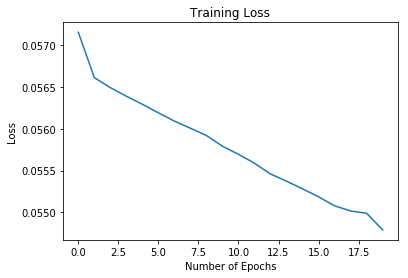

In [20]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.plot(train_loss)
plt.show()

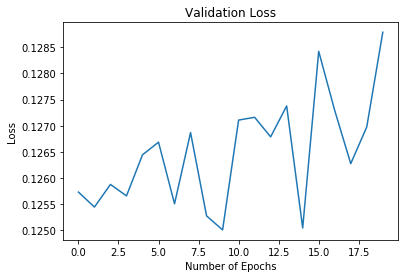

In [21]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.plot(val_loss)
plt.show()

### Spectrogram

In [22]:
best_model, train_loss, val_loss = train_model(trainData, valData, 'spectrogram')
torch.save(best_model, './std_spec_model.pth')

Epoch 0/19


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceT

Epoch: 0,Loss:0.07394
Epoch: 0,Loss:0.16193
Epoch 1/19
Epoch: 1,Loss:0.04543
Epoch: 1,Loss:0.15547
Epoch 2/19
Epoch: 2,Loss:0.04065
Epoch: 2,Loss:0.16590
Epoch 3/19
Epoch: 3,Loss:0.03797
Epoch: 3,Loss:0.17411
Epoch 4/19
Epoch: 4,Loss:0.03614
Epoch: 4,Loss:0.16488
Epoch 5/19
Epoch: 5,Loss:0.03479
Epoch: 5,Loss:0.16600
Epoch 6/19
Epoch: 6,Loss:0.03369
Epoch: 6,Loss:0.16792
Epoch 7/19
Epoch: 7,Loss:0.03278
Epoch: 7,Loss:0.16179
Epoch 8/19
Epoch: 8,Loss:0.03197
Epoch: 8,Loss:0.16529
Epoch 9/19
Epoch: 9,Loss:0.03131
Epoch: 9,Loss:0.16914
Epoch 10/19
Epoch:10,Loss:0.03072
Epoch:10,Loss:0.16225
Epoch 11/19
Epoch:11,Loss:0.03022
Epoch:11,Loss:0.16076
Epoch 12/19
Epoch:12,Loss:0.02973
Epoch:12,Loss:0.16482
Epoch 13/19
Epoch:13,Loss:0.02932
Epoch:13,Loss:0.17974
Epoch 14/19
Epoch:14,Loss:0.02891
Epoch:14,Loss:0.17602
Epoch 15/19
Epoch:15,Loss:0.02857
Epoch:15,Loss:0.16805
Epoch 16/19
Epoch:16,Loss:0.02823
Epoch:16,Loss:0.17206
Epoch 17/19
Epoch:17,Loss:0.02791
Epoch:17,Loss:0.17757
Epoch 18/19
E

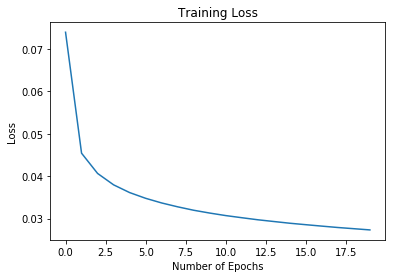

In [23]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.plot(train_loss)
plt.show()

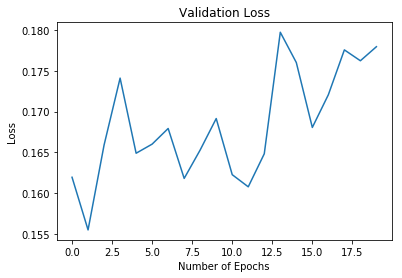

In [24]:
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.plot(val_loss)
plt.show()

## Testing

In [21]:
def mse(clean, recon):
    if clean.shape[0] > recon.shape[0]:
        new = np.zeros(clean.shape)
        new[:recon.shape[0]] = recon
        recon = new 
        
    elif clean.shape[0] < recon.shape[0]:
        new = np.zeros(clean.shape)
        new[:clean.shape[0]] = clean
        clean = new
        
    return ((clean - recon)**2).mean()

In [106]:
# testData = data.DataLoader(testDataLoader()) 
def generate_test_files(model, testPath, savePath, num_files, input_type, output_type, parameter):

    max_test = parameter[0]
    min_test = parameter[1]
    mean_test = parameter[2]
    std_test = parameter[3]
    
    deno = max_test - min_test
    
    loss = []
    
    for step in range(1800):
        print(step)
#         if step == 10:
#             break

        ss,sr = librosa.load(testPath + "dirty_" + str(step+1)+'.wav')
        S = librosa.stft(ss, n_fft = 512, hop_length = 160, win_length = 320)
        
        abs_S = abs(S)
        S_phase = S/abs_S
        
        if input_type == 'norm':
            abs_S = (abs_S - min_test)/deno
        elif input_type == 'std':
            abs_S = (abs_S - mean_test)/std_test
#             print(abs_S)
        else:
            print('error')
        
        audio = torch.tensor(10*np.log10(abs_S)).T
        
#         print(audio.shape)
        
        model.eval()
        mask = model(audio)

        mask = np.transpose(mask.cpu().data.numpy().squeeze())
        
        if output_type == 'spec':
            output = mask 
        else:
            output = mask * abs_S
        
#         print(output)
#         if(input_type == 'std'):
#             output = np.clip(output, min_test, output.max())
        output = S_phase*output

        
        output = librosa.istft(output, hop_length=160,win_length=320) 
  
        
        name = "clean"+str(step+1)+".wav"
    
        
        
#         print("name = ",name)
        try:
            librosa.output.write_wav(savePath+name, output, 16000)
        except:
            continue
            
        loss.append(mse(ss, output))
#         print(ss.shape)
#         print(output.shape)
        
        
    return loss

In [75]:
# testPyPath = './GeneratedData/npy/test'
testPath = './GeneratedData/Test/Dirty/'
path = './GeneratedData/npy/'
num_files = len(os.listdir(testPath))
file = path + 'dirty_test.npy'
a = np.abs(np.load(file))
max_test = np.max(a, axis=1, keepdims=True)
min_test = np.min(a, axis=1, keepdims=True)
std_test = np.std(a, axis=1, keepdims=True)
mean_test = np.mean(a, axis=1, keepdims=True)
parameter_test = [max_test, min_test, std_test, mean_test]

### For Normalized Data

In [41]:
ip_type = "norm"

#### IBM

In [42]:
m1 = Net()
m1.load_state_dict(torch.load('./norm_ibm_model.pth'))
print(m1)

Net(
  (fc1): Linear(in_features=257, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=257, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


In [43]:
savePath = './result_frame/ibm_norm/'
op_type = 'ibm'
loss = generate_test_files(m1, testPath, savePath, num_files, ip_type, op_type,parameter_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

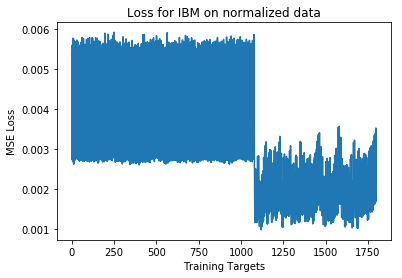

In [44]:
plt.xlabel('Training Targets')
plt.ylabel('MSE Loss')
plt.title('Loss for IBM on normalized data')
plt.plot(loss)
plt.show()

#### IRM

In [45]:
m2 = Net()
m2.load_state_dict(torch.load('./norm_irm_model.pth'))
print(m2)

Net(
  (fc1): Linear(in_features=257, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=257, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


In [46]:
savePath = './result_frame/irm_norm/'
op_type = 'irm'
loss = generate_test_files(m2, testPath, savePath, num_files, ip_type, op_type, parameter_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

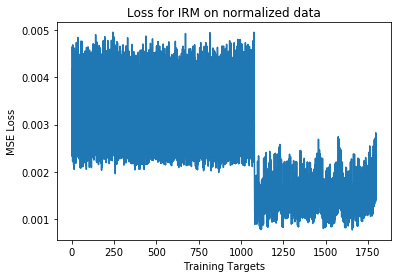

In [47]:
plt.xlabel('Training Targets')
plt.ylabel('MSE Loss')
plt.title('Loss for IRM on normalized data')
plt.plot(loss)
plt.show()

#### FFT Mask

In [48]:
m3 = Net()
m3.load_state_dict(torch.load('./norm_fft_model.pth'))
print(m3)

Net(
  (fc1): Linear(in_features=257, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=257, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


In [49]:
savePath = './result_frame/fft_norm/'
op_type = 'fft'
loss = generate_test_files(m3, testPath, savePath, num_files, ip_type, op_type, parameter_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

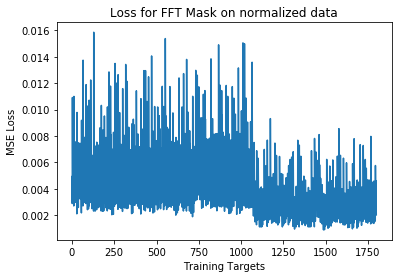

In [50]:
plt.xlabel('Training Targets')
plt.ylabel('MSE Loss')
plt.title('Loss for FFT Mask on normalized data')
plt.plot(loss)
plt.show()

#### Spectrogram

In [51]:
m4 = Net()
m4.load_state_dict(torch.load('./norm_spec_model.pth'))
print(m4)

Net(
  (fc1): Linear(in_features=257, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=257, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


In [52]:
savePath = './result_frame/spec_norm/'
op_type = 'spec'
loss = generate_test_files(m4, testPath, savePath, num_files, ip_type, op_type, parameter_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

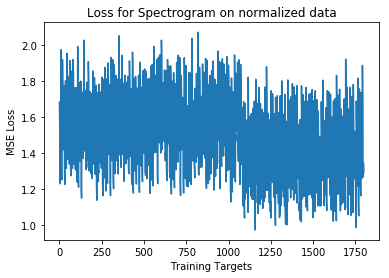

In [53]:
plt.xlabel('Training Targets')
plt.ylabel('MSE Loss')
plt.title('Loss for Spectrogram on normalized data')
plt.plot(loss)
plt.show()

### For Standardized Input

In [104]:
ip_type = "std"

#### IBM

In [107]:
m1 = Net()
m1.load_state_dict(torch.load('./std_ibm_model.pth'))
print(m1)

Net2(
  (fc1): Linear(in_features=257, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=257, bias=True)
)


In [108]:
savePath = './result_frame/ibm_std/'
op_type = 'ibm'
loss = generate_test_files(m1, testPath, savePath, num_files, ip_type, op_type,parameter_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

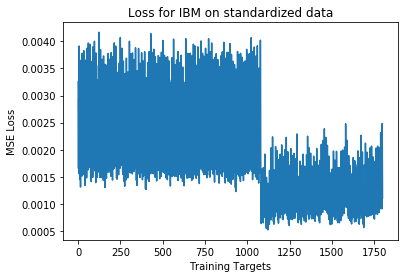

In [109]:
plt.xlabel('Training Targets')
plt.ylabel('MSE Loss')
plt.title('Loss for IBM on standardized data')
plt.plot(loss)
plt.show()

#### IRM

In [110]:
m2 = Net()
m2.load_state_dict(torch.load('./std_irm_model.pth'))
print(m2)

Net2(
  (fc1): Linear(in_features=257, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=257, bias=True)
)


In [111]:
savePath = './result_frame/irm_std/'
op_type = 'irm'
loss = generate_test_files(m2, testPath, savePath, num_files, ip_type, op_type, parameter_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

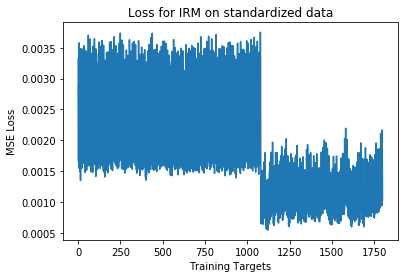

In [112]:
plt.xlabel('Training Targets')
plt.ylabel('MSE Loss')
plt.title('Loss for IRM on standardized data')
plt.plot(loss)
plt.show()

#### FFT Mask

In [114]:
m3 = Net()
m3.load_state_dict(torch.load('./std_fft_model.pth'))
print(m3)

Net2(
  (fc1): Linear(in_features=257, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=257, bias=True)
)


In [115]:
savePath = './result_frame/fft_std/'
op_type = 'fft'
loss = generate_test_files(m3, testPath, savePath, num_files, ip_type, op_type, parameter_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

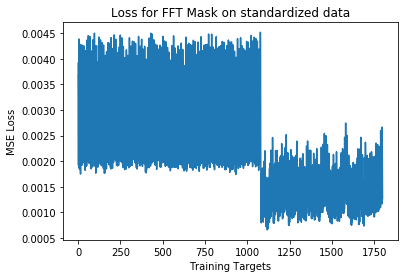

In [116]:
plt.xlabel('Training Targets')
plt.ylabel('MSE Loss')
plt.title('Loss for FFT Mask on standardized data')
plt.plot(loss)
plt.show()

#### Spectrogram

In [117]:
m4 = Net()
m4.load_state_dict(torch.load('./std_spec_model.pth'))
print(m4)

Net2(
  (fc1): Linear(in_features=257, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=257, bias=True)
)


In [118]:
savePath = './result_frame/spec_std/'
op_type = 'spec'
loss = generate_test_files(m4, testPath, savePath, num_files, ip_type, op_type, parameter_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

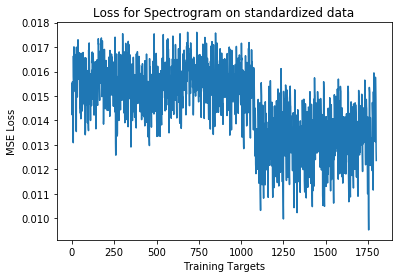

In [119]:
plt.xlabel('Training Targets')
plt.ylabel('MSE Loss')
plt.title('Loss for Spectrogram on standardized data')
plt.plot(loss)
plt.show()

##### Q1. Discuss how the different DNNs perform. 

As we can see in the Test Loss DNNs with standardized input data is better.   
Also we can see that DNNs with output as IRM and FFT mask have better loss then IRM and Spectrogram  

According to MSE Loss in Test Data  
Best input Standardized Data  
Best Output FFT Mask

The output is not very intelligibile. Some Hyperparameter tuning may help. 

###### Q2. Discuss how data normalization vs data standardization impacts performance.

As we can see in the plots Data Standardization performs better than normalization.   

This is because when we do standardization the input space in all dimensions shrinks and becomes somewhat equal(changes the distribution of data). The mean is 0 and standard deviation is 1  
 
But in Normalization does nothing of this sort. As it retains the original distribution.  

Source - https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks

##### Q3. Listen to the signals and explain how the performance varies audibly. Also submit two sound examples (clean speech, noisy speech, enhanced speech) for each training target. Describe how the different targets perform at speech enhancement, both computationally and perceptually.

Audibly the outputs which had standardized input sound better    

Spectrogram and IBM outputs aren't good audibly. Whereas outputs of FFT-Mask and IRM sound better   

According to Audibility in Test Data    
Best input Standardized Data    
Best Output FFT Mask    

As discussed in Q1 computationally   
We can see in the Test Loss DNNs with standardized input data is better.  
Also we can see that DNNs with output as IRM and FFT mask have better loss then IRM and Spectrogram  

According to MSE Loss/ Computation in Test Data  
Best input Standardized Data  
Best Output FFT Mask  

### Changes made

Instead of saving each segment as a separate file, I stacked all of the segments in 1 file and made the necessary changes in the DataLoader. I did this because the reading 4.5 Million files is a CPU intensive task. This makes the training very slow.  

Also I changed the batch size from 10k to 20k as it gives a better loss. I even tried 50k but it wasn't very efficient.  



### Things I Noticed

1. File I/O matters during training as this can overload the CPU.  
2. Shuffling the data while training helps as the Network doesn't try to generalize on the training data
3. The Test MSE loss in all the outputs is wierdly skewed. The left half has a higher loss than the right half. I suspect that the model better generalizes to female voice because the left half contains voices of males and the right half contains voices of females